<H3>Practica 2: Biométrico de marcha humana con video</h3>
<i>Diana Jaramillo</i></br>
Esta practica tiene como objetivo practicar el analisis de caracteristicas en un video de marcha para intentar identificar a la persona en la toma, se hizo uso de mediapipe para la extraccion de los features de las extremidades mientras la persona camina y se utilizan esos puntos para entrenar a los modelos de predicción.

In [2]:
import pandas as pd
import mediapipe
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
#Definicion de las direcciones de los archivos a usar
loc_videos="E:\\MarchaSensores\\Videos"
loc_tests="E:\\MarchaSensores\\Videos\\TEST"
loc_etiquetas="E:\\MarchaSensores\\Videos\\Etiquetas_nombres.xlsx"


In [3]:
#Cargar los archivos de los videos
df_videos=pd.DataFrame(columns=["Nombre","Ruta"])
for video in os.listdir(loc_videos):
    if video.endswith(".bag"):
        df_videos = pd.concat([df_videos, pd.DataFrame([{"Nombre": video, "Ruta": os.path.join(loc_videos, video)}])], ignore_index=True)
df_videos.head()
df_videos_test=pd.DataFrame(columns=["Nombre","Ruta"])
for video in os.listdir(loc_tests):
    if video.endswith(".bag"):
        df_videos_test = pd.concat([df_videos_test, pd.DataFrame([{"Nombre": video, "Ruta": os.path.join(loc_tests, video)}])], ignore_index=True)

In [4]:
# Cargar el archivo de etiquetas
etiquetas_df = pd.read_excel(loc_etiquetas)
#Limpiar etiquetas de nombre y unirla con los videos
etiquetas_df['Nombre'] = etiquetas_df['Nombre'].str.replace(r'_(01|02|03|04)$', '', regex=True)
etiquetas_df["Nombre"]= etiquetas_df["Nombre"].str.replace('_',' ')
df_videos['Persona']=etiquetas_df['Nombre']
df_videos.head()
#Las etiquetas de los videos de prueba varian a las que se tienen con los datos del set de entrenamiento, por lo que se asigno manualmente una etiqueta representativa del video para poder analizar el a que asocia los modelos los datos presentados que no sonparte del set de entrenamiento
nombres_test=['Chica','Chica','Chica reloj','Joan','Joan','Joan Vaso','Chico','Chico','Chico telefono','Tony','Tony Mano','Tony Vaso']
df_videos_test['Persona']=nombres_test



Los Datos de los features de la poses en los videos se obtuvieron usando el codigo que fue proporcionado al momento de grabar los videos, como las librerias requieren de su entorno especifico, se hizo otro notebook para extraer los datos y crear archivos csv relacionados con el video y la pose. El codigo con el que se consiguieron los features y cuales fueron se muestra a continuacion pero no se puede correr en el entorno.

Recuperacion de los features extraidos

In [5]:
loc_features="E:\\MarchaSensores"
df_features=pd.DataFrame(columns=["archivo","Landmark","value","pose_num"])
for archivo in os.listdir(loc_features):
    if archivo.endswith(".csv") and not archivo.startswith("TEST_"):
        df_temp = pd.read_csv(os.path.join(loc_features, archivo))
        df_temp['archivo'] = archivo
        df_features = pd.concat([df_features, df_temp], ignore_index=True)
df_features.head()
df_features_test=pd.DataFrame(columns=["archivo","Landmark","value","pose_num"])
for archivo in os.listdir(loc_features):
    if archivo.endswith(".csv") and archivo.startswith("TEST_"):
        df_temp = pd.read_csv(os.path.join(loc_features, archivo))
        df_temp['archivo'] = archivo
        df_features_test = pd.concat([df_features_test, df_temp], ignore_index=True)
df_features_test.head()

,archivo,Landmark,value,pose_num
0,TEST_grabacion_20260206_163238.bag_Features.csv,Nose,"(0.504973828792572, 0.35027068853378296, 0.036...",1
1,TEST_grabacion_20260206_163238.bag_Features.csv,Left shoulder,"(0.5109855532646179, 0.34868109226226807, 0.00...",1
2,TEST_grabacion_20260206_163238.bag_Features.csv,Right shoulder,"(0.5197872519493103, 0.410483717918396, -0.005...",1
3,TEST_grabacion_20260206_163238.bag_Features.csv,Left elbow,"(0.5162360668182373, 0.3855403661727905, -0.04...",1
4,TEST_grabacion_20260206_163238.bag_Features.csv,Right elbow,"(0.5322249531745911, 0.44694697856903076, 0.00...",1


Para entrenar los datos, se hara mediante las poses que se detectaron por cada video, como se intentara detectar por pose, se colocaron las coordenadas normalizadas que mediapipe ofrece en cada lanmark y estos se consideraron como los valores que usa sola pose tiene

In [6]:
transpose_df = df_features.pivot(index=['archivo', 'pose_num'], columns='Landmark', values='value').reset_index()
transpose_df.head()
transpose_df_test = df_features_test.pivot(index=['archivo', 'pose_num'], columns='Landmark', values='value').reset_index()
transpose_df['archivo'] = transpose_df['archivo'].str.replace('_Features.csv', '', regex=False)
transpose_df_test['archivo'] = transpose_df_test['archivo'].str.replace('_Features.csv', '', regex=False)
transpose_df_test['archivo'] = transpose_df_test['archivo'].str.replace('TEST_', '', regex=False)
transpose_df_test.head()

Landmark,archivo,pose_num,Left ankle,Left elbow,Left foot index,Left heel,Left hip,Left knee,Left shoulder,Left wrist,Nose,Right ankle,Right elbow,Right foot index,Right heel,Right hip,Right knee,Right shoulder,Right wrist
0,grabacion_20260206_163238.bag,1,"(0.4887625575065613, 0.510037899017334, 0.0294...","(0.5162360668182373, 0.3855403661727905, -0.04...","(0.4901526868343353, 0.5212967991828918, -0.01...","(0.48458942770957947, 0.5186569094657898, 0.02...","(0.5015087723731995, 0.3907013237476349, 0.005...","(0.5041170120239258, 0.45819249749183655, 0.02...","(0.5109855532646179, 0.34868109226226807, 0.00...","(0.5174940228462219, 0.4344229996204376, -0.08...","(0.504973828792572, 0.35027068853378296, 0.036...","(0.5031304955482483, 0.6114134192466736, -0.04...","(0.5322249531745911, 0.44694697856903076, 0.00...","(0.5052616596221924, 0.6355148553848267, -0.09...","(0.4996088743209839, 0.6210936903953552, -0.04...","(0.5106314420700073, 0.4296800494194031, -0.00...","(0.5037989616394043, 0.5190392732620239, -0.02...","(0.5197872519493103, 0.410483717918396, -0.005...","(0.5277761220932007, 0.4607035517692566, 0.035..."
1,grabacion_20260206_163238.bag,2,"(0.5056137442588806, 0.6179986596107483, 0.004...","(0.5233065485954285, 0.41967031359672546, -0.0...","(0.5064510703086853, 0.6490393877029419, -0.06...","(0.5009077191352844, 0.6352030038833618, 0.004...","(0.5104684233665466, 0.4175122082233429, 0.002...","(0.5091137886047363, 0.5321248769760132, -0.02...","(0.5159912705421448, 0.3827580213546753, -0.15...","(0.527702271938324, 0.4617783725261688, -0.058...","(0.5050097703933716, 0.35037803649902344, -0.2...","(0.4960178732872009, 0.5815742015838623, 0.055...","(0.5187329053878784, 0.4223513901233673, -0.12...","(0.4946924149990082, 0.6100465059280396, 0.006...","(0.49610844254493713, 0.5913149118423462, 0.06...","(0.5081719160079956, 0.41484445333480835, -0.0...","(0.5031313896179199, 0.5104190707206726, -0.01...","(0.5150351524353027, 0.378966361284256, -0.166...","(0.5184398293495178, 0.454084187746048, -0.094..."
2,grabacion_20260206_163238.bag,3,"(0.5023409128189087, 0.5960844159126282, 0.042...","(0.4947143495082855, 0.41054201126098633, -0.0...","(0.5091969966888428, 0.6185929179191589, -0.00...","(0.4995194673538208, 0.6069965958595276, 0.043...","(0.5102396607398987, 0.4032140374183655, 0.010...","(0.503552258014679, 0.5131069421768188, 0.0050...","(0.5074275135993958, 0.37067294120788574, -0.1...","(0.4819848835468292, 0.4659425914287567, -0.03...","(0.5029908418655396, 0.3500698208808899, -0.19...","(0.49261412024497986, 0.5587264895439148, 0.05...","(0.5351473093032837, 0.43194591999053955, -0.1...","(0.4914063811302185, 0.5781844854354858, 0.019...","(0.49077874422073364, 0.567914605140686, 0.057...","(0.5146884322166443, 0.4226817786693573, -0.01...","(0.505377471446991, 0.502274751663208, -0.0195...","(0.5237875580787659, 0.38938409090042114, -0.1...","(0.5322155356407166, 0.46923884749412537, -0.0..."
3,grabacion_20260206_163238.bag,4,"(0.5052350759506226, 0.6339471936225891, -0.03...","(0.508512020111084, 0.4334385097026825, -0.117...","(0.5046709775924683, 0.649793267250061, -0.093...","(0.5049031376838684, 0.6451625823974609, -0.03...","(0.5129222869873047, 0.4263748228549957, -0.01...","(0.5043560862541199, 0.5303980112075806, -0.05...","(0.5158731341362, 0.39295363426208496, -0.2083...","(0.4988608956336975, 0.469658225774765, -0.038...","(0.504183292388916, 0.35007956624031067, -0.28...","(0.4912380874156952, 0.4900399446487427, 0.261...","(0.5320514440536499, 0.42936524748802185, -0.1...","(0.4853212237358093, 0.4926585853099823, 0.259...","(0.4899348020553589, 0.4971756637096405, 0.276...","(0.5073748230934143, 0.41491422057151794, 0.01...","(0.5022850632667542, 0.4663892984390259, 0.112...","(0.5213996171951294, 0.3835856318473816, -0.20...","(0.5318825840950012, 0.47344934940338135, -0.0..."
4,grabacion_20260206_163238.bag,5,"(0.5160309076309204, 0.590666651725769, 0.2067...","(0.530968785285949

Con los datos ya en su posicion correcta, se añadieron las etiquetas correspondientes a cada pose detectada por el video, esto se aplico tanto para los datos de los videos de entrenamiento como los de prueba para que tengan en comun las columnas y se pueda predecir

In [7]:
merge_df = pd.merge(transpose_df, df_videos[['Nombre', 'Persona']], left_on='archivo', right_on='Nombre', how='left')
merge_df.drop(columns=['Nombre'], inplace=True)
merge_df.head()
merge_df_test = pd.merge(transpose_df_test, df_videos_test[['Nombre', 'Persona']], left_on='archivo', right_on='Nombre', how='left')
merge_df_test.drop(columns=['Nombre'], inplace=True)
merge_df_test.head()

,archivo,pose_num,Left ankle,Left elbow,Left foot index,Left heel,Left hip,Left knee,Left shoulder,Left wrist,Nose,Right ankle,Right elbow,Right foot index,Right heel,Right hip,Right knee,Right shoulder,Right wrist,Persona
0,grabacion_20260206_163238.bag,1,"(0.4887625575065613, 0.510037899017334, 0.0294...","(0.5162360668182373, 0.3855403661727905, -0.04...","(0.4901526868343353, 0.5212967991828918, -0.01...","(0.48458942770957947, 0.5186569094657898, 0.02...","(0.5015087723731995, 0.3907013237476349, 0.005...","(0.5041170120239258, 0.45819249749183655, 0.02...","(0.5109855532646179, 0.34868109226226807, 0.00...","(0.5174940228462219, 0.4344229996204376, -0.08...","(0.504973828792572, 0.35027068853378296, 0.036...","(0.5031304955482483, 0.6114134192466736, -0.04...","(0.5322249531745911, 0.44694697856903076, 0.00...","(0.5052616596221924, 0.6355148553848267, -0.09...","(0.4996088743209839, 0.6210936903953552, -0.04...","(0.5106314420700073, 0.4296800494194031, -0.00...","(0.5037989616394043, 0.5190392732620239, -0.02...","(0.5197872519493103, 0.410483717918396, -0.005...","(0.5277761220932007, 0.4607035517692566, 0.035...",Chica
1,grabacion_20260206_163238.bag,2,"(0.5056137442588806, 0.6179986596107483, 0.004...","(0.5233065485954285, 0.41967031359672546, -0.0...","(0.5064510703086853, 0.6490393877029419, -0.06...","(0.5009077191352844, 0.6352030038833618, 0.004...","(0.5104684233665466, 0.4175122082233429, 0.002...","(0.5091137886047363, 0.5321248769760132, -0.02...","(0.5159912705421448, 0.3827580213546753, -0.15...","(0.527702271938324, 0.4617783725261688, -0.058...","(0.5050097703933716, 0.35037803649902344, -0.2...","(0.4960178732872009, 0.5815742015838623, 0.055...","(0.5187329053878784, 0.4223513901233673, -0.12...","(0.4946924149990082, 0.6100465059280396, 0.006...","(0.49610844254493713, 0.5913149118423462, 0.06...","(0.5081719160079956, 0.41484445333480835, -0.0...","(0.5031313896179199, 0.5104190707206726, -0.01...","(0.5150351524353027, 0.378966361284256, -0.166...","(0.5184398293495178, 0.454084187746048, -0.094...",Chica
2,grabacion_20260206_163238.bag,3,"(0.5023409128189087, 0.5960844159126282, 0.042...","(0.4947143495082855, 0.41054201126098633, -0.0...","(0.5091969966888428, 0.6185929179191589, -0.00...","(0.4995194673538208, 0.6069965958595276, 0.043...","(0.5102396607398987, 0.4032140374183655, 0.010...","(0.503552258014679, 0.5131069421768188, 0.0050...","(0.5074275135993958, 0.37067294120788574, -0.1...","(0.4819848835468292, 0.4659425914287567, -0.03...","(0.5029908418655396, 0.3500698208808899, -0.19...","(0.49261412024497986, 0.5587264895439148, 0.05...","(0.5351473093032837, 0.43194591999053955, -0.1...","(0.4914063811302185, 0.5781844854354858, 0.019...","(0.49077874422073364, 0.567914605140686, 0.057...","(0.5146884322166443, 0.4226817786693573, -0.01...","(0.505377471446991, 0.502274751663208, -0.0195...","(0.5237875580787659, 0.38938409090042114, -0.1...","(0.5322155356407166, 0.46923884749412537, -0.0...",Chica
3,grabacion_20260206_163238.bag,4,"(0.5052350759506226, 0.6339471936225891, -0.03...","(0.508512020111084, 0.4334385097026825, -0.117...","(0.5046709775924683, 0.649793267250061, -0.093...","(0.5049031376838684, 0.6451625823974609, -0.03...","(0.5129222869873047, 0.4263748228549957, -0.01...","(0.5043560862541199, 0.5303980112075806, -0.05...","(0.5158731341362, 0.39295363426208496, -0.2083...","(0.4988608956336975, 0.469658225774765, -0.038...","(0.504183292388916, 0.35007956624031067, -0.28...","(0.4912380874156952, 0.4900399446487427, 0.261...","(0.5320514440536499, 0.42936524748802185, -0.1...","(0.4853212237358093, 0.4926585853099823, 0.259...","(0.4899348020553589, 0.4971756637096405, 0.276...","(0.5073748230934143, 0.41491422057151794, 0.01...","(0.5022850632667542, 0.4663892984390259, 0.112...","(0.5213996171951294, 0.3835856318473816, -0.20...","(0.5318825840950012, 0.47344934940338135, -0.0...",Chica
4,grabacion_20260206_163238.bag,5,"(0.5160309076309204, 0.590666651725769, 0.2067

Como medida general con el numero de pose, que es el dato que no esta normalizado, se calcularon estadisticos descriptivos como el maximo que hay en un video y el promedio de numero de poses 

In [8]:
prom_poses=merge_df['pose_num'].mean()
print(f"El promedio de poses por video es: {prom_poses}")

prom_poses_test=merge_df_test['pose_num'].mean()
print(f"El promedio de poses por video de prueba es: {prom_poses_test}")
max_poses=merge_df['pose_num'].max()
print(f"El máximo número de poses en un video es: {max_poses}")
max_poses_test=merge_df_test['pose_num'].max()
print(f"El máximo número de poses en un video de prueba es: {max_poses_test}")

El promedio de poses por video es: 69.51326595072646
El promedio de poses por video de prueba es: 61.811334824757644
El máximo número de poses en un video es: 240
El máximo número de poses en un video de prueba es: 189


Para que los videos inicien en poses en donde ya esta en marcha se opto por desechar las primeras 10 registradas de cada video, ya que estas solian salir no tan exactas, asi como a normalizacion de los valores del numero de pose para que este valor no afecte en los modelos.

In [9]:
#Quitar las primeras 10 poses de cada persona para evitar que el modelo se sobreentrene con las primeras poses, que no salen bien
from sklearn.preprocessing import MinMaxScaler
merge_df = merge_df[merge_df['pose_num'] > 10]
merge_df.head()
#Normalizazion de los datos de numero de pose
merge_df['pose_num'] = MinMaxScaler().fit_transform(merge_df[['pose_num']])
merge_df.head()
merge_df_test = merge_df_test[merge_df_test['pose_num'] > 10]
merge_df_test['pose_num'] = MinMaxScaler().fit_transform(merge_df_test[['pose_num']])
merge_df_test.head()


,archivo,pose_num,Left ankle,Left elbow,Left foot index,Left heel,Left hip,Left knee,Left shoulder,Left wrist,Nose,Right ankle,Right elbow,Right foot index,Right heel,Right hip,Right knee,Right shoulder,Right wrist,Persona
10,grabacion_20260206_163238.bag,0.000000,"(0.5201789140701294, 0.6672846078872681, 0.012...","(0.5326184034347534, 0.4439008831977844, -0.05...","(0.5211811661720276, 0.7007004022598267, -0.06...","(0.5183161497116089, 0.679746150970459, 0.0132...","(0.5143064260482788, 0.49439725279808044, 0.00...","(0.5169402956962585, 0.5826898813247681, -0.03...","(0.5253195762634277, 0.3928222954273224, -0.09...","(0.5370535850524902, 0.48641565442085266, -0.1...","(0.5036760568618774, 0.34622710943222046, -0.2...","(0.5053404569625854, 0.6261292695999146, 0.186...","(0.47264569997787476, 0.44722235202789307, -0....","(0.5044730305671692, 0.6613588333129883, 0.154...","(0.5079053640365601, 0.6296159029006958, 0.200...","(0.49025052785873413, 0.49693307280540466, -0....","(0.4990804195404053, 0.5777117013931274, 0.021...","(0.4844129979610443, 0.39279502630233765, -0.1...","(0.47342443466186523, 0.4895220398902893, -0.1...",Chica
11,grabacion_20260206_163238.bag,0.005618,"(0.5192528963088989, 0.6729375720024109, -0.00...","(0.5322070717811584, 0.445994108915329, -0.047...","(0.5214934349060059, 0.7039192914962769, -0.08...","(0.5163847208023071, 0.6851696968078613, -0.00...","(0.5146211981773376, 0.49631327390670776, 0.00...","(0.5174161791801453, 0.5874292850494385, -0.04...","(0.5257344841957092, 0.3951514959335327, -0.07...","(0.5375007390975952, 0.4873880445957184, -0.10...","(0.5038713812828064, 0.3509233593940735, -0.21...","(0.5057700872421265, 0.6269967555999756, 0.170...","(0.47276023030281067, 0.4498388171195984, -0.0...","(0.5048830509185791, 0.661677360534668, 0.1435...","(0.5085105299949646, 0.6315811276435852, 0.184...","(0.490292489528656, 0.49805471301078796, -0.00...","(0.49860090017318726, 0.5791718363761902, 0.01...","(0.4853299856185913, 0.3970869481563568, -0.09...","(0.47382789850234985, 0.4902639389038086, -0.1...",Chica
12,grabacion_20260206_163238.bag,0.011236,"(0.5195555686950684, 0.6794323325157166, -0.05...","(0.5330665111541748, 0.4521930515766144, -0.03...","(0.5217407941818237, 0.7091577053070068, -0.14...","(0.5164111256599426, 0.6923025846481323, -0.05...","(0.5140544176101685, 0.5063890218734741, -9.94...","(0.5174425840377808, 0.5883066058158875, -0.06...","(0.5262762904167175, 0.40045666694641113, -0.0...","(0.5370048880577087, 0.49416863918304443, -0.0...","(0.5044160485267639, 0.3515391945838928, -0.20...","(0.5059227347373962, 0.6306130886077881, 0.255...","(0.47274643182754517, 0.45344579219818115, -0....","(0.5042639970779419, 0.6637566089630127, 0.233...","(0.5090357661247253, 0.6336095333099365, 0.271...","(0.4892229437828064, 0.5072641372680664, -2.73...","(0.4985947012901306, 0.5815256834030151, 0.077...","(0.48520204424858093, 0.3990294635295868, -0.0...","(0.47593462467193604, 0.4939456582069397, -0.1...",Chica
13,grabacion_20260206_163238.bag,0.016854,"(0.5186770558357239, 0.6850265860557556, 0.004...","(0.532848596572876, 0.45304447412490845, -0.00...","(0.5175712704658508, 0.7131795883178711, -0.06...","(0.5177419781684875, 0.6970076560974121, 0.005...","(0.5167291760444641, 0.5100365877151489, 0.001...","(0.5162070989608765, 0.5962048172950745, -0.03...","(0.5264623165130615, 0.40272536873817444, -0.0...","(0.537833034992218, 0.4970744252204895, -0.055...","(0.5052554607391357, 0.35423725843429565, -0.1...","(0.5070420503616333, 0.631537914276123, 0.1423...","(0.4734300971031189, 0.456573486328125, -0.056...","(0.5027897357940674, 0.6670974493026733, 0.116...","(0.5104279518127441, 0.6345841288566589, 0.155...","(0.4910750985145569, 0.5096327662467957, -0.00...","(0.49920517206192017, 0.5879693627357483, -0.0...","(0.4847508370876312, 0.40107262134552, -0.0577...","(0.47545182704925537, 0.4955652952194214, -0.1...",Chica
14,grabacion_20260206_163238.bag,0.022472,"(0.517

Division de los datos y las etiquetas

In [10]:
from sklearn.model_selection import train_test_split
features=merge_df.drop(columns=['archivo', 'Persona'])
labels=merge_df['Persona']
test_features=merge_df_test.drop(columns=['archivo', 'Persona'])
test_labels=merge_df_test['Persona']

Como se esta analizando una serie de poses y la prediccion se quiere hacer en base a la marcha de una persona, se opto por modelos que puedan recordar la informacion de estados pasados de las poses para que no solo considere un momento exacto de la marcha.

Modelo LSTM

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
import ast
X=[]
y=[]
#Seleccionar segmentos de 30 poses para predecir quien es quien esta en el video
Window_size = 30

# Convertir características en vectores numéricos
feature_cols = features.columns

def expand_row(row):
    values = []
    for col in feature_cols:
        v = row[col]
        if isinstance(v, str) and v.startswith("(") and v.endswith(")"):
            v = ast.literal_eval(v)
        if isinstance(v, (tuple, list, np.ndarray)):
            values.extend(v)
        else:
            values.append(v)
    return np.array(values, dtype=np.float32)

X_values = np.vstack(features.apply(expand_row, axis=1).values)
X_values_test = np.vstack(test_features.apply(expand_row, axis=1).values)

# Encode labels a numero enteros para el modelo
label_encoder1 = LabelEncoder()
label_encodertest = LabelEncoder()  
y_encoded = label_encoder1.fit_transform(labels)
y_test_encoded = label_encodertest.fit_transform(test_labels)

#Hacer segmentos de 30 poses para entrenar el modelo
for i in range(Window_size, len(X_values)):
    X.append(X_values[i-Window_size:i])
    y.append(y_encoded[i])

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)
#Dividir los datos en entrenamiento y validación interna
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = len(label_encoder1.classes_)

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))#capa de dropout para evitar sobreajuste en el modelo
model.add(Dense(num_classes, activation='softmax'))#union de las capas para el modelo de red neuronal recurrente, con una capa LSTM y una capa densa de salida con activacion softmax para clasificacion multiclase
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
163/163 [==============================] - 2s 9ms/step - loss: 2.3253 - accuracy: 0.1816 - val_loss: 2.1583 - val_accuracy: 0.2349
Epoch 2/20
163/163 [==============================] - 1s 8ms/step - loss: 2.0197 - accuracy: 0.2766 - val_loss: 1.8181 - val_accuracy: 0.3972
Epoch 3/20
163/163 [==============================] - 1s 8ms/step - loss: 1.5813 - accuracy: 0.4388 - val_loss: 1.0694 - val_accuracy: 0.6459
Epoch 4/20
163/163 [==============================] - 1s 8ms/step - loss: 1.2176 - accuracy: 0.5656 - val_loss: 0.8669 - val_accuracy: 0.7185
Epoch 5/20
163/163 [==============================] - 1s 8ms/step - loss: 0.9287 - accuracy: 0.6712 - val_loss: 0.7081 - val_accuracy: 0.7582
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 0.7384 - accuracy: 0.7230 - val_loss: 0.5158 - val_accuracy: 0.8532
Epoch 7/20
163/163 [==============================] - 1s 8ms/step - loss: 0.7043 - accuracy: 0.7396 - val_loss: 0.4720 - val_accuracy: 0.8325
Epoch 

38/38 [==============================] - 0s 3ms/step
['Diana Itzel' 'Diana Itzel' 'Diana Itzel' ... 'Tony' 'Tony' 'Tony']
19/19 [==============================] - 0s 3ms/step


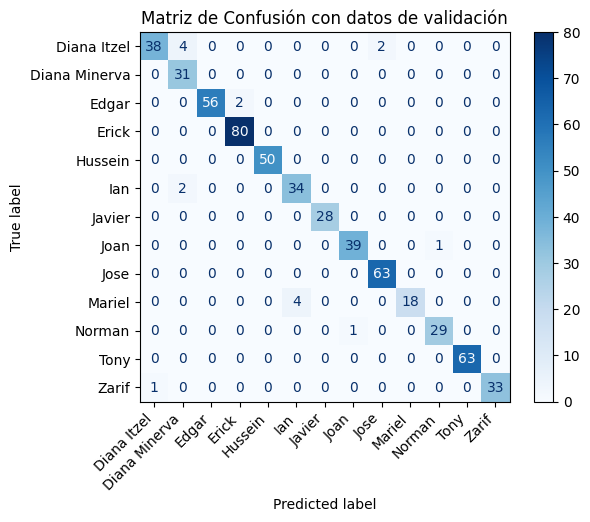

19/19 [==============================] - 0s 4ms/step
F1 Score en validación: 0.9705317922672472


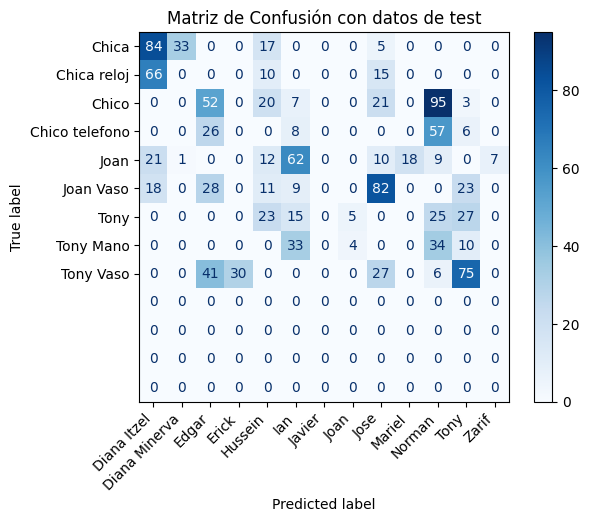

F1 Score: 0.16045991347296346
Tendencia central: 7.047337278106509 Etiqueta: Norman
Dispersion: 16.925108497248694


In [124]:
#Prediccion en el set de prueba
import matplotlib.pyplot as plt
X_test_seq = np.array(
	[X_values_test[i - Window_size:i] for i in range(Window_size, len(X_values_test))],
	dtype=np.float32
)
predictions = model.predict(X_test_seq)
predicted_labels = label_encoder1.inverse_transform(np.argmax(predictions, axis=1))

print(predicted_labels)
#Matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


y_test_seq = np.array(
	[y_test_encoded[i] for i in range(Window_size, len(y_test_encoded))],
	dtype=np.int32
)

conf_matrix_train= confusion_matrix(y_val, model.predict(X_val).argmax(axis=1))
cm_display_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=label_encoder1.classes_)
cm_display_train.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('Matriz de Confusión con datos de validación')
plt.show()
print('F1 Score en validación:', classification_report(y_val, model.predict(X_val).argmax(axis=1), output_dict=True)['weighted avg']['f1-score'])

conf_matrix = confusion_matrix(y_test_seq, np.argmax(predictions, axis=1))
class_report = classification_report(y_test_seq, np.argmax(predictions, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder1.classes_)
cm_display.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(len(label_encodertest.classes_)), labels=label_encodertest.classes_)
plt.title('Matriz de Confusión con datos de test')
plt.show()

print('F1 Score:', classification_report(y_test_seq, np.argmax(predictions, axis=1), output_dict=True)['weighted avg']['f1-score'])
print('Tendencia central:', conf_matrix.mean(), 'Etiqueta:', label_encoder1.classes_[np.argmax(conf_matrix.mean(axis=0))])
print('Dispersion:', conf_matrix.std())

LSTM parece funcionar bien al reconocer a Tony, sin importar que este no solo estaba caminando si no que tambien hacia movimientos extras o traia objetos.
Como los datos de testque fueron ofrecidos eran con solo dos personas con las que se entreno el modelo(Tony y Joan), el modelo intento predecir a lo mas parecido con las caracteristicas con las que fue entrenado, de alguna forma, es interesante que asigara la etiqueta de la chica que solo iba camiando a la etiqueta de la compañera Diana Itzel, ya que seria con la cual tienen mas en comun, asi como en el caso de Norman, que se le identifico como el otro chico que no se tenia registrado, esto puede ser a que tengan una complexion similar y los parametros sean similares en las poses que fueron seleccionadas.

Modelo CNN

Las CNN son usadas principalmente para analisis de imagenes fijas, pero su capacidad de implementar capas permite tener cierta memoria de los patrones que tengan los datos, una desventaja es que requieren una gran canidad de datos, cosa que no se tiene, pero estas son posibles de paralelizar si es que se realizan con varias capas que se conecten entre si.

In [72]:
from keras.layers import Conv1D, GlobalAveragePooling1D
cnnmodel= Sequential()
cnnmodel.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnnmodel.add(GlobalAveragePooling1D())
cnnmodel.add(Dense(num_classes, activation='softmax'))
cnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnnmodel.summary()
cnnmodel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 28, 64)            10048     
                                                                 
 global_average_pooling1d_13  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_28 (Dense)            (None, 13)                845       
                                                                 
Total params: 10,893
Trainable params: 10,893
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
163/163 [==============================] - 1s 3ms/step - loss: 2.4367 - accuracy: 0.1684 - val_loss: 2.3088 - val_accuracy: 0.2591
Epoch 2/40
163/163 [==============================] - 0s 2ms/step - loss: 2.2230 - accuracy: 0.2512 - val

19/19 [==============================] - 0s 722us/step


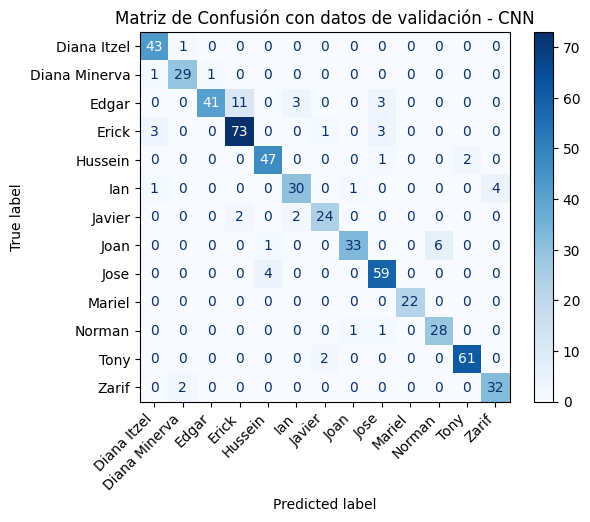

F1 Score CNN: 0.900257725381578
38/38 [==============================] - 0s 827us/step


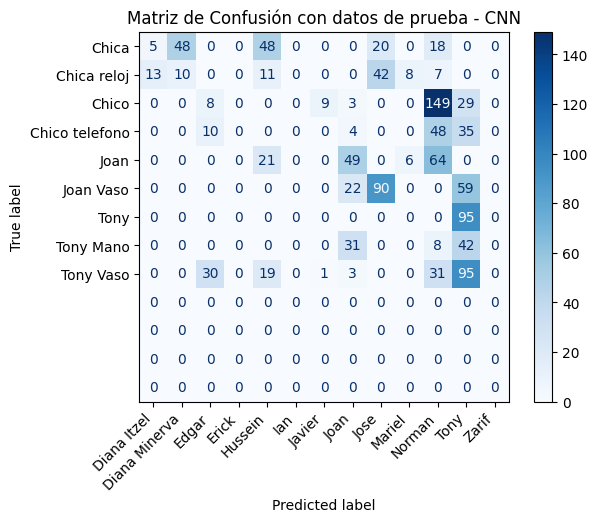

F1 Score CNN (Test): 0.0710071812886015
Tendencia central CNN (Test): 7.047337278106509 Etiqueta: Tony
Dispersion CNN (Test): 20.08585437974571


In [125]:
#Prediccion en el set de entreno
cnn_preds = np.argmax(cnnmodel.predict(X_val), axis=1)
cnn_conf_matrix = confusion_matrix(y_val, cnn_preds)
cm_display_cnn = ConfusionMatrixDisplay(confusion_matrix=cnn_conf_matrix, display_labels=label_encoder1.classes_)
cm_display_cnn.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(len(label_encoder1.classes_)), labels=label_encoder1.classes_)
plt.title('Matriz de Confusión con datos de validación - CNN')
plt.show()
f1_score_cnn = classification_report(y_val, cnn_preds, output_dict=True)['weighted avg']['f1-score']
print('F1 Score CNN:', f1_score_cnn)
#Prediccion en el set de prueba
cnn_preds_test = np.argmax(cnnmodel.predict(X_test_seq), axis=1)
y_test_encoded_aligned = LabelEncoder().fit_transform(test_labels[Window_size:])

cnn_conf_matrix_test = confusion_matrix(
	y_test_encoded_aligned,
	cnn_preds_test,
	labels=np.arange(len(label_encoder1.classes_))
)
cm_display_cnn_test = ConfusionMatrixDisplay(
	confusion_matrix=cnn_conf_matrix_test,
	display_labels=label_encoder1.classes_
)
cm_display_cnn_test.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(len(label_encodertest.classes_)), labels=label_encodertest.classes_)
plt.title('Matriz de Confusión con datos de prueba - CNN')
plt.show()
f1_score_cnn_test = classification_report(
	y_test_encoded_aligned,
	cnn_preds_test,
	output_dict=True
)['weighted avg']['f1-score']
print('F1 Score CNN (Test):', f1_score_cnn_test)
print('Tendencia central CNN (Test):', cnn_conf_matrix_test.mean(), 'Etiqueta:', label_encoder1.classes_[np.argmax(cnn_conf_matrix_test.mean(axis=0))])
print('Dispersion CNN (Test):', cnn_conf_matrix_test.std())

Este modelo tiene un f1 menor que el LSTM, sigue reconociendo mas a tony y las muestras donde se esta haciendo algo mas aparte de caminar, este modelo si pudo reconocer algunas veces a joan, lo cual el otro no lo pudo hacer, en el caso de la chica, el modelo no fue tan consistente, ya que si asignaba a una que otra participante mujer como posible prediccion, pero tambien se tienen predicciones hacia otros, como con jose, el Dr. Hussein o norman. Como con el modelo anterior, relaciono los datos que se tienen del chico que no esta en el dataset de prueba con norman, lo cual sigue siendo entendible ya que es de los que tendrian la complexion similar, asi como la condicon en la que se grabo el video es mas similar la direccion que tomo al caminar.

Modelo de CNN + LSTM

Como CNN tiene una memoria de largo plazo de los patrones limitada al añadir capas del modelo LSTM se podria compensar, solo que vuelve mas sensible el armado del modelo.

In [111]:
from keras.layers import ConvLSTM2D, Reshape, GlobalAveragePooling2D
mix_model = Sequential()
# Keras ya proporciona un modelo ConvLSTM2D que combina convoluciones y LSTM, por lo que no es necesario crear una capa personalizada. Simplemente podemos usar ConvLSTM2D directamente en nuestro modelo.
mix_model.add(Reshape((X_train.shape[1], X_train.shape[2], 1, 1), input_shape=(X_train.shape[1], X_train.shape[2])))
mix_model.add(Dense(num_classes, activation='relu'))
mix_model.add(ConvLSTM2D(64, kernel_size=(3, 1), activation='tanh'))
mix_model.add(GlobalAveragePooling2D())
mix_model.add(Dense(num_classes, activation='softmax'))
mix_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mix_model.summary()
mix_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 30, 52, 1, 1)      0         
                                                                 
 dense_37 (Dense)            (None, 30, 52, 1, 13)     26        
                                                                 
 conv_lstm2d_11 (ConvLSTM2D)  (None, 50, 1, 64)        59392     
                                                                 
 global_average_pooling2d_4   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_38 (Dense)            (None, 13)                845       
                                                                 
Total params: 60,263
Trainable params: 60,263
Non-trainable params: 0
_________________________________________________

19/19 [==============================] - 1s 64ms/step
F1 Score Mix: 0.9100895272232047
38/38 [==============================] - 3s 67ms/step


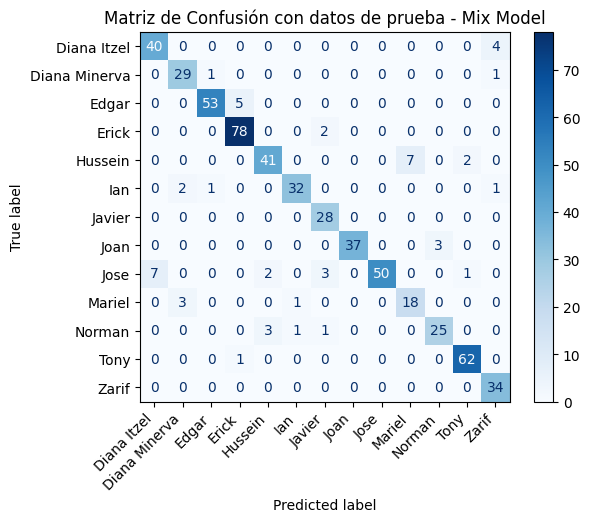

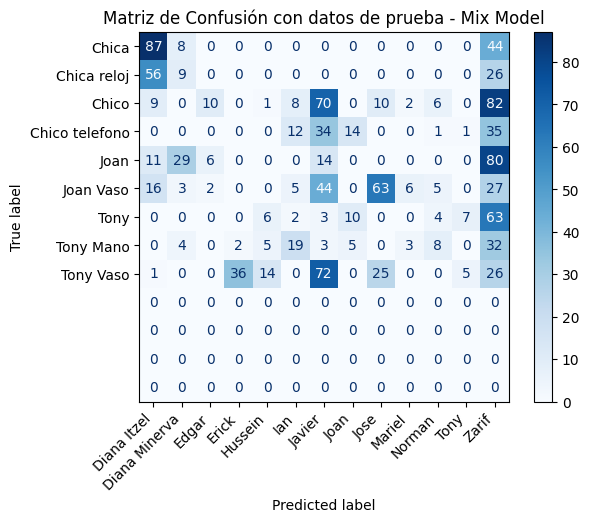

F1 Score Mix (Test): 0.12995994768962352
Tendencia central Mix Model (Test): 7.047337278106509 Etiqueta: Zarif
Dispersion Mix Model (Test): 16.87188433683661


In [127]:
#prediccion set de train
mix_preds = np.argmax(mix_model.predict(X_val), axis=1)
mix_conf_matrix = confusion_matrix(y_val, mix_preds)
cm_display_mix = ConfusionMatrixDisplay(confusion_matrix=mix_conf_matrix, display_labels=label_encoder1.classes_)
cm_display_mix.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('Matriz de Confusión con datos de prueba - Mix Model')
plt.plot()
print('F1 Score Mix:', classification_report(y_val, mix_preds, output_dict=True)['weighted avg']['f1-score'])
#prediccion set de prueba
mix_preds_test = np.argmax(mix_model.predict(X_test_seq), axis=1)
y_test_encoded_aligned = LabelEncoder().fit_transform(test_labels[Window_size:])
mix_conf_matrix_test = confusion_matrix(
    y_test_encoded_aligned,
    mix_preds_test,
    labels=np.arange(len(label_encoder1.classes_))
)
cm_display_mix_test = ConfusionMatrixDisplay(
    confusion_matrix=mix_conf_matrix_test,
    display_labels=label_encoder1.classes_
)
cm_display_mix_test.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(len(label_encodertest.classes_)), labels=label_encodertest.classes_)
plt.title('Matriz de Confusión con datos de prueba - Mix Model')
plt.show()
print('F1 Score Mix (Test):', classification_report(
    y_test_encoded_aligned,
    mix_preds_test,
    output_dict=True
)['weighted avg']['f1-score'])
print('Tendencia central Mix Model (Test):', mix_conf_matrix_test.mean(), 'Etiqueta:', label_encoder1.classes_[np.argmax(mix_conf_matrix_test.mean(axis=0))])
print('Dispersion Mix Model (Test):', mix_conf_matrix_test.std())

El modelo a pesar de que deberia de arreglar la debilidad de CNN, pareciera que si tiene un sobreajuste al mostrar tantas predicciones con una sola etiqueta, hasta eso en cuestiones como la chica que no esta dentro del dataset, si se le asigno algo un poco mas congruente como la etiqueta de Diana Itzel, a diferencia de los modelos pasados en donde fallaban, pero con Tony y en CNN Joan que son sos dos que se encuentran en los dos datasets, si los reconoce en algunos segmentos.
Este modelo tomo mas en entrenar y los resultados que dieron no parece que sean mejores que los anteriores a pesar de tener el F1 de 0.129, comparandolo con el LSTM solo, que fue el que tiene el F1 mas alto con los datos de prueba(0.16), se puede apreciar que al combinar LSTM y CNN si se mejora el F1 de CNN solo, pero esto se logro al tener que añadir mas uniones entre las capas, lo cual hizo que el entrenamiento fuera mas tardado.